In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
from geodatasets import get_path
import numpy as np
import xarray as xr
from scipy import interpolate
from tqdm import tqdm

import sys

sys.path.append("..")
from scripts.dicts import *
from scripts.great_circle_distance import great_circle_distance
from scripts.paths import *

/var/folders/cv/s_h5gzxd0h71t_d875wqxgzh0000gn/T/ipykernel_68490/3852728062.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Pathdata: /Volumes/imau01/rapid/RACMO2.3p2/FGRN055


In [2]:
ds = xr.open_dataset("/Volumes/imau01/rapid/RACMO2.3p2/FGRN055_1940/Monthly/runoff_monthlyS_FGRN055_BN_RACMO2.3p2_ERA5_3h_1940_FGRN055_193909_202312.nc")


In [3]:
ds_runoff = ds.sel(time='2023')['runoff']
ds_lat = ds['lat']
ds_lon = ds['lon']


In [4]:
fpath_adj_sect = "/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/FWclean/data/temp/adjusted_section_numbers_slater.nc"
fpath_masks1k = "/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/FWclean/data/temp/masks1k.nc"
folder_MARRACMO1km = "/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/FWclean/data/raw/liquid/"

ds_adj_sect = xr.open_dataset(fpath_adj_sect)
ds_masks1k = xr.open_dataset(fpath_masks1k)

In [5]:
lats_source = ds.lat.values
lons_source = ds.lon.values
lats_target = ds_masks1k.LAT.values
lons_target = ds_masks1k.LON.values
ds_runoff_tundra2023 = xr.Dataset()


for month in tqdm(range(12)):
    values_source = ds_runoff.isel(time=month).values
    time = ds_runoff.time.isel(time=month).values
    runoff_tundra = interpolate.griddata((lats_source.flatten(), lons_source.flatten()), values_source.flatten(),
                                (lats_target, lons_target), 
                                method='nearest')
    runoff_tundra = np.reshape(runoff_tundra, lats_target.shape)
    da_runoff_tundra = xr.DataArray(runoff_tundra, dims=['y','x'], coords={'y': ds_adj_sect.y, 'x': ds_adj_sect.x}, name= 'Liquid Runoff Tundra').expand_dims(time=[time])
    ds_runoff_tundra2023 = xr.combine_by_coords([ds_runoff_tundra2023, da_runoff_tundra])

ds_runoff_tundra2023




<xarray.Dataset> Size: 388MB
Dimensions:               (time: 12, y: 2700, x: 1496)
Coordinates:
  * time                  (time) datetime64[ns] 96B 2023-01-16 ... 2023-12-16
  * y                     (y) float32 11kB -3.355e+06 -3.354e+06 ... -6.556e+05
  * x                     (x) float32 6kB -6.39e+05 -6.38e+05 ... 8.56e+05
Data variables:
    Liquid Runoff Tundra  (time, y, x) float64 388MB 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [61]:
ds_runoff_tundra2023['Tundra'] = ds_runoff_tundra2023['Basins']
ds_runoff_tundra2023['Tundra'].values = ds_masks1k['LSM'].where(ds_masks1k['Promicemask'] == 0).values
ds_runoff_tundra2023 ['Liquid Runoff Tundra'] = ds_runoff_tundra2023['Liquid Runoff Tundra'].where(ds_runoff_tundra2023['Tundra'] == 1)

In [65]:
# ds_runoff_tundra2023.to_netcdf(f"{pathIMAU02}RACMO2.3p2/FGRN055/Downscaling_GR/Monthly/runoff_tundra.2023.RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.tundra.nc")
# also export to pathdatatemp
ds_runoff_tundra2023.to_netcdf(f"{pathDataTemp}runoff_tundra.2023.RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.tundra.nc")


PermissionError: [Errno 13] Permission denied: '/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/FWclean/data/temp/runoff_tundra.2023.RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.tundra.nc'

In [5]:
ds_runoff_tundra2023 = xr.open_dataset(f"{pathDataTemp}runoff_tundra.2023.RACMO2.3p2_ERA5_3h_FGRN055.1km.MM.tundra.nc", engine='netcdf4')
ds_runoff_tundra2023['Basins'] = ds_masks1k['LSM']
ds_runoff_tundra2023['Basins'].values = ds_adj_sect['section_numbers_adjusted'].values
ds_runoff_tundra2023_Basins = ds_runoff_tundra2023.groupby('Basins').sum()

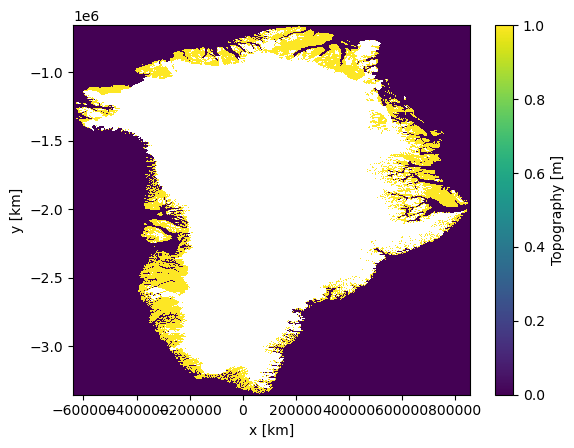

In [45]:
ds_runoff_tundra2023_Basins.astype(int).astype(str).rename({'1':'SE'})

ValueError: cannot rename '1' because it is not a variable or dimension in this dataset